In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# General dependencies
import os
import random
import pathlib
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-10-14 08:01:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-14 08:01:34 (99.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Obtain the paths to the training and the test sets
training_set_path = "/content/drive/MyDrive/Project_4/calc_train_cropped"
test_set_path = "/content/drive/MyDrive/Project_4/calc_test_cropped"

# # Trying example dataset
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
# unzip_data("10_food_classes_all_data.zip")
# training_set_path = "10_food_classes_all_data/train/"
# test_set_path = "10_food_classes_all_data/test/"

efn_net_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
res_net_url = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"

In [5]:
# Get the class names programmetically
data_dir = pathlib.Path(training_set_path)
# Created a list of class_names from the sub-directories
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
#class_names = class_names[1:]
print(class_names)

['BENIGN' 'BENIGN_WITHOUT_CALLBACK' 'MALIGNANT']


In [6]:
# Walk through a directory
walk_through_dir(data_dir)

There are 3 directories and 0 images in '/content/drive/MyDrive/Project_4/calc_train_cropped'.
There are 0 directories and 553 images in '/content/drive/MyDrive/Project_4/calc_train_cropped/MALIGNANT'.
There are 0 directories and 473 images in '/content/drive/MyDrive/Project_4/calc_train_cropped/BENIGN_WITHOUT_CALLBACK'.
There are 0 directories and 528 images in '/content/drive/MyDrive/Project_4/calc_train_cropped/BENIGN'.


In [ ]:
# Walk through a directory
# for dirpath, dirnames, filenames in os.walk(training_set_path):
#     print(f"{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
# Visualize random signal-set
def getANDview_random_img(target_dir, target_class):
  # Setup the target directory (we will view images from here)
  target_folder = target_dir + target_class
  # Get a random img file path
  random_img_name = random.sample(os.listdir(target_folder),1) # this will output as a list
  print(random_img_name)
  # Read the image the plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_img_name[0])
  plt.imshow(img, cmap='gray')
  plt.title(target_class)
  plt.axis("off")
  print(f"Img Shape: {img.shape}")
  return img

In [ ]:
# # Test the getANDview_random_img
# curr_img = getANDview_random_img(target_dir = training_set_path + "/", target_class = "MALIGNANT")
# rows, cols = curr_img.shape
# print(f"Current img shape = {curr_img.shape}")

In [ ]:
# tf.constant(curr_img)

In [7]:
# Data preprocessing for transfer learning
IMG_SIZE = (200, 200) # define image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = training_set_path,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_set_path,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 1554 files belonging to 3 classes.
Found 326 files belonging to 3 classes.


In [8]:
# Check out the class names of our dataset
train_data.class_names

['BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT']

In [9]:
test_data.class_names

['BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT']

In [ ]:
# See an example batch of data
for images, labels in train_data.take(1):
  print(images, labels)

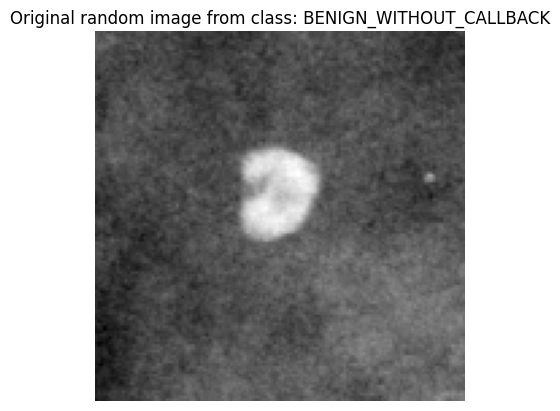

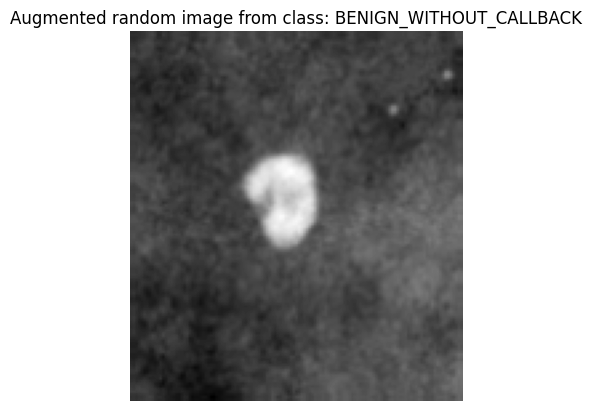

In [8]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomHeight(0.1),
  layers.RandomWidth(0.1),
  layers.RandomZoom(0.1),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

# View a random image
target_class = random.choice(train_data.class_names) # choose a random class
target_dir = training_set_path+ "/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img,cmap='gray') # plot the target image
# plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Add a channel dimension to the grayscale image
img = img[..., tf.newaxis]

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255., cmap='gray') # requires normalization after augmentation
# plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [9]:
# Setup input shape and base model, freezing the base model layers
input_shape = (200, 200, 3)

def create_tf_model(input_shape: tuple[int, int, int], # = input_shape,
                    output_shape: int, # = 3,
                    learning_rate: float, # = 0.001,
                    training: bool) -> tf.keras.Model: #  = False)

    # 1. Create base model with tf.keras.applications
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)  #ResNet50V2(include_top=False) #ConvNeXtXLarge(include_top=False) #. Xception(include_top=False) # #
    # base_model = tf.keras.applications.EfficientNetV2L(include_top=False, input_shape=input_shape, weights='imagenet')

    # 2. Freeze the base model (so the pre-learned patterns remain)
    base_model.trainable = training

    # 3. Create inputs into the base model
    inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

    # Add in data augmentation Sequential model as a layer
    x = data_augmentation(inputs)

    # 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
    x = base_model(x, training=training)
    # Check data shape after passing it to base_model
    print(f"Shape after base_model: {x.shape}")

    # 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
    x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    print(f"After GlobalAveragePooling2D(): {x.shape}")
    # 7. Create the output activation layer
    outputs = tf.keras.layers.Dense(output_shape, activation="softmax", name="output_layer")(x)
    # 8. Combine the inputs with the outputs into a model
    model = tf.keras.Model(inputs, outputs)
    # 9. Compile the model
    model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=["accuracy"])
    return model

In [10]:
# Create a model for transfer learning (THE ORIGINAL MODEL)
model_0 = create_tf_model(input_shape, 3, 1e-4, False)
model_0.summary()

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, None, None, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, None   0         
 ial)                        )                                   
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                

In [ ]:
# # 10. Fit the model (we use less steps for validation so it's faster)
# history_0 = model_0.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
#                         validation_data=test_data,
#                         # Go through less of the validation data so epochs are faster (we want faster experiments!)
#                         validation_steps=int(0.25 * len(test_data)),
#                         # Track our model's training logs for visualization later
#                         callbacks=[create_tensorboard_callback("transfer_learning", "feature_extract_step")])
# # Check out our model's training curves
# plot_loss_curves(history_0)

In [11]:
# # Setup checkpoint path
# checkpoint_path = "/content/drive/MyDrive/Project_4/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# # Create a ModelCheckpoint callback that saves the model's weights only
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                          save_weights_only=True, # set to False to save the entire model
#                                                          save_best_only=True, # save only the best model weights instead of a model every epoch
#                                                          save_freq="epoch", # save every epoch
#                                                          verbose=1)

In [11]:
# Fit the model saving checkpoints every epoch
history_0 = model_0.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)) #, # do less steps per validation (quicker)
                        # callbacks=[create_tensorboard_callback("transfer_learning", "data_aug"), checkpoint_callback]
                        )


Epoch 1/10
49/49 [==============================] - 229s 4s/step - loss: 1.1038 - accuracy: 0.3449 - val_loss: 1.0709 - val_accuracy: 0.3438
Epoch 2/10
49/49 [==============================] - 18s 346ms/step - loss: 1.0298 - accuracy: 0.4768 - val_loss: 1.0248 - val_accuracy: 0.5000
Epoch 3/10
49/49 [==============================] - 16s 303ms/step - loss: 0.9720 - accuracy: 0.5290 - val_loss: 0.9816 - val_accuracy: 0.4531
Epoch 4/10
49/49 [==============================] - 16s 298ms/step - loss: 0.9219 - accuracy: 0.5586 - val_loss: 0.9569 - val_accuracy: 0.4844
Epoch 5/10
49/49 [==============================] - 13s 232ms/step - loss: 0.9070 - accuracy: 0.5547 - val_loss: 0.9542 - val_accuracy: 0.5000
Epoch 6/10
49/49 [==============================] - 13s 226ms/step - loss: 0.8809 - accuracy: 0.5656 - val_loss: 0.9303 - val_accuracy: 0.5469
Epoch 7/10
49/49 [==============================] - 13s 246ms/step - loss: 0.8597 - accuracy: 0.5798 - val_loss: 0.7963 - val_accuracy: 0.6406
E

11/11 [==============================] - 2s 120ms/step - loss: 0.9030 - accuracy: 0.5092


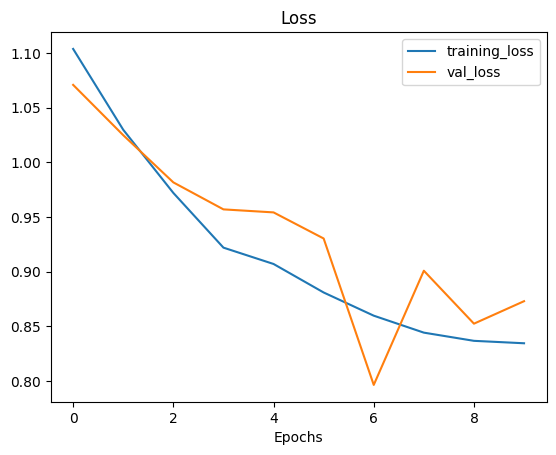

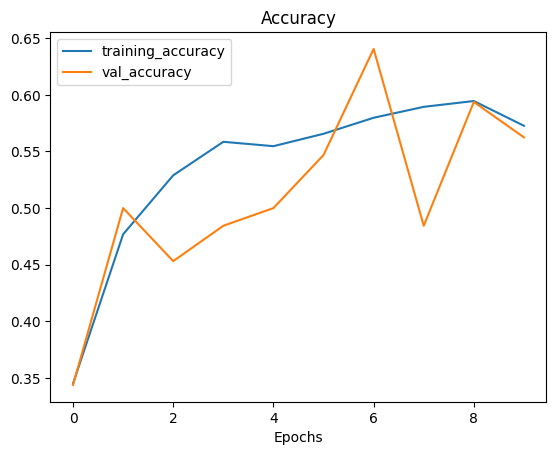

In [12]:
# Evaluate on the test data **USING TRANSFER LEARNING AND NO FINE TUNING
results_data_aug = model_0.evaluate(test_data)
results_data_aug
# Plot model loss curves
plot_loss_curves(history_0)

In [1]:
# # Load in saved model weights and evaluate model
# model_0.load_weights(checkpoint_path)
# loaded_weights_model_results = model_0.evaluate(test_data)
# # If the results from our native model and the loaded weights are the same, this should output True
# results_data_aug == loaded_weights_model_results

In [18]:
# # Check the difference between the two results (small values)
# print(np.array(results_data_aug) - np.array(loaded_weights_model_results))

In [31]:
# # Access the base_model layers of model_2
# model_0_base_model = model_0.layers[2]
# model_0_base_model.name
# # How many layers are trainable in our model_2_base_model?
# print(len(model_0_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)
# # Check which layers are tuneable (trainable)
# for layer_number, layer in enumerate(model_0_base_model.layers):
#   print(layer_number, layer.name, layer.trainable)

In [15]:
# Layers in loaded model
model_0.layers

In [16]:
for layer_number, layer in enumerate(model_0.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7ad0d1334fd0> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x7ad0ec9645e0> | Trainable? True
Layer number: 2 | Layer name: resnet50v2 | Layer type: <keras.src.engine.functional.Functional object at 0x7ad0d13e5a20> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7ad0ec181540> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x7ad0d13e7760> | Trainable? True


In [33]:
# # Access the base_model layers of model_0
# model_0_base_model = model_0.layers[2]
# model_0_base_model.name

In [19]:
# How many layers are trainable in our model_2_base_model?
# print(len(model_0_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)

In [ ]:
# # Check which layers are tuneable (trainable)
# for layer_number, layer in enumerate(model_0_base_model.layers):
#   print(layer_number, layer.name, layer.trainable)

In [14]:
# Create another same exact model
model_1 = create_tf_model(input_shape, 3, 1e-4, False)
model_1.summary()

# from tensorflow.keras.models import clone_model
# model_1 = clone_model(model_0)
# model_1.set_weights(model_0.get_weights())
# model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model_1.layers[2].name)
# Count the number of trainable variables before unfreezing in model_1
print("Number of trainable layers in model_1: ", len(model_1.layers[2].trainable_variables))

Shape after base_model: (None, None, None, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, None   0         
 ial)                        )                                   
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                               

In [15]:
# In model_0, make the last 'counts' of layers trainable
model_0.layers[2].trainable = True
# Freeze all layers except for the last few layers
last_layers = 30
for layer in model_0.layers[2].layers[:-last_layers]:
  layer.trainable = False

# Check the number of trainable variables after unfreezing
print(f"Number of trainable variables in model_0 after unfreezing the last {last_layers} layers: {len(model_0.layers[2].trainable_variables)}")

Number of trainable variables in model_0 after unfreezing the last 30 layers: 26


In [16]:
# In model_1, make all the layers trainable
model_1.layers[2].trainable = True
print(f"Number of trainable variables after unfreezing all layers: {len(model_1.layers[2].trainable_variables)}")

Number of trainable variables after unfreezing all layers: 241


In [17]:
# Recompile the whole model (always recompile after any adjustments to a model)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [18]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [19]:
# Check which layers are tuneable (trainable) in model_0
for layer_number, layer in enumerate(model_0.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [20]:
# Check which layers are tuneable (trainable) in model_1
for layer_number, layer in enumerate(model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 True
1 rescaling_1 True
2 normalization_1 True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 block4a_a

In [21]:
# Fine tune for another 15 epochs
fine_tune_epochs = 25

# Refit the model (same as model_0 except with more trainable layers)
history_finetune_0 = model_0.fit(train_data,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          initial_epoch=history_0.epoch[-1], # start from previous last epoch
                                          validation_steps=int(0.25 * len(test_data)) #,
                                          # callbacks=[create_tensorboard_callback("transfer_learning", "fine_tune_0")]
                                 ) # name experiment appropriately

Epoch 10/25
49/49 [==============================] - 26s 244ms/step - loss: 0.8014 - accuracy: 0.5888 - val_loss: 0.8090 - val_accuracy: 0.5781
Epoch 11/25
49/49 [==============================] - 10s 185ms/step - loss: 0.7440 - accuracy: 0.6396 - val_loss: 0.9708 - val_accuracy: 0.4531
Epoch 12/25
49/49 [==============================] - 9s 172ms/step - loss: 0.7217 - accuracy: 0.6506 - val_loss: 0.7964 - val_accuracy: 0.5781
Epoch 13/25
49/49 [==============================] - 10s 187ms/step - loss: 0.6947 - accuracy: 0.6474 - val_loss: 0.7694 - val_accuracy: 0.5156
Epoch 14/25
49/49 [==============================] - 10s 190ms/step - loss: 0.6748 - accuracy: 0.6564 - val_loss: 0.9345 - val_accuracy: 0.4688
Epoch 15/25
49/49 [==============================] - 10s 197ms/step - loss: 0.6625 - accuracy: 0.6647 - val_loss: 0.7560 - val_accuracy: 0.7031
Epoch 16/25
49/49 [==============================] - 10s 178ms/step - loss: 0.6538 - accuracy: 0.6763 - val_loss: 0.7730 - val_accuracy: 

11/11 [==============================] - 1s 54ms/step - loss: 0.8631 - accuracy: 0.5368


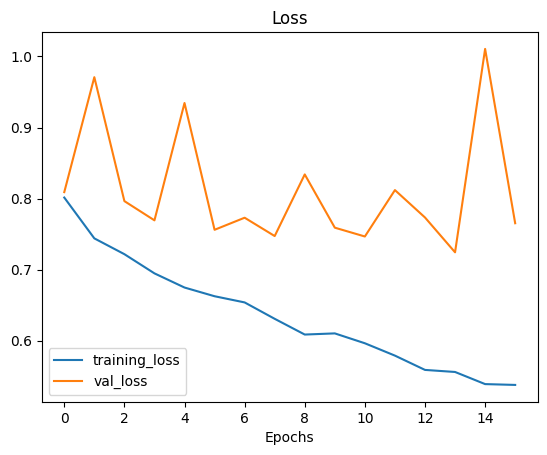

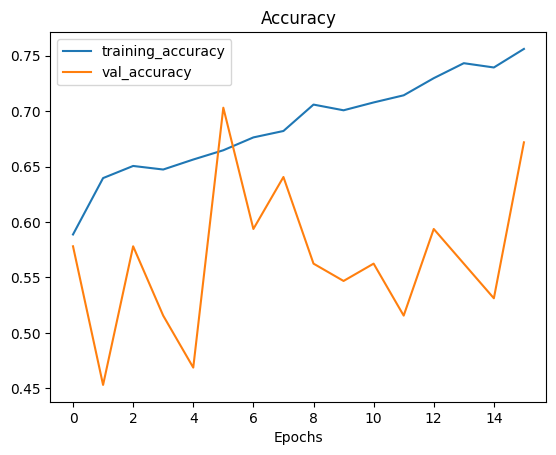

In [22]:
# Evaluate the model on the test data
results_tf_ft_0 = model_0.evaluate(test_data)
results_tf_ft_0
# Plot model loss curves
plot_loss_curves(history_finetune_0)

In [23]:
# Refit the model (same as model_0 except with more trainable layers)
history_finetune_1 = model_1.fit(train_data,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          initial_epoch=history_0.epoch[-1], # start from previous last epoch
                                          validation_steps=int(0.25 * len(test_data)) #,
                                          # callbacks=[create_tensorboard_callback("transfer_learning", "fine_tune_0")]
                                 ) # name experiment appropriately

Epoch 10/25
49/49 [==============================] - 90s 835ms/step - loss: 0.8368 - accuracy: 0.5843 - val_loss: 0.8000 - val_accuracy: 0.5625
Epoch 11/25
49/49 [==============================] - 35s 682ms/step - loss: 0.7124 - accuracy: 0.6416 - val_loss: 1.0139 - val_accuracy: 0.4844
Epoch 12/25
49/49 [==============================] - 28s 541ms/step - loss: 0.6800 - accuracy: 0.6622 - val_loss: 0.7456 - val_accuracy: 0.5938
Epoch 13/25
49/49 [==============================] - 25s 473ms/step - loss: 0.6319 - accuracy: 0.6834 - val_loss: 0.7853 - val_accuracy: 0.5938
Epoch 14/25
49/49 [==============================] - 25s 490ms/step - loss: 0.5589 - accuracy: 0.7329 - val_loss: 0.8387 - val_accuracy: 0.5938
Epoch 15/25
49/49 [==============================] - 21s 410ms/step - loss: 0.5367 - accuracy: 0.7400 - val_loss: 0.6023 - val_accuracy: 0.7344
Epoch 16/25
49/49 [==============================] - 22s 426ms/step - loss: 0.5007 - accuracy: 0.7510 - val_loss: 0.6669 - val_accuracy:

11/11 [==============================] - 2s 54ms/step - loss: 1.0167 - accuracy: 0.5706


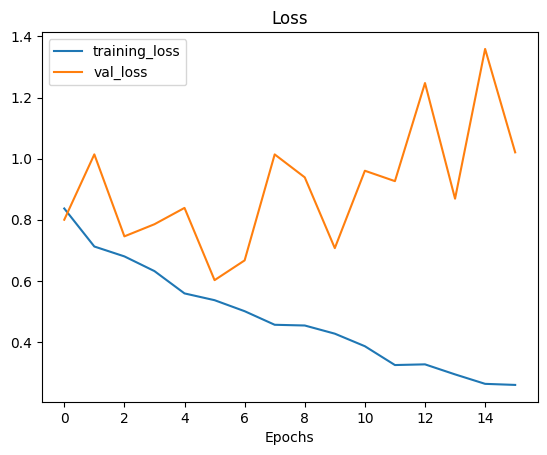

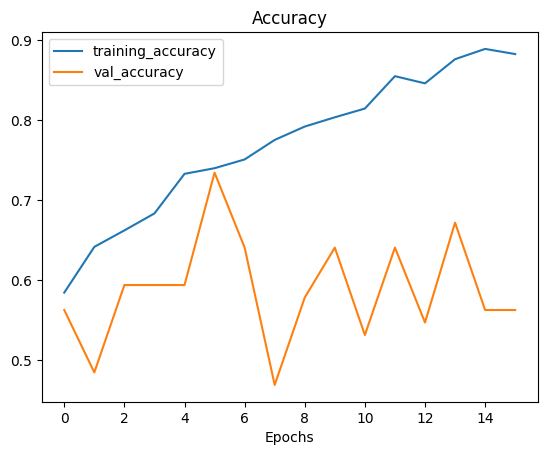

In [24]:
# Evaluate the model on the test data
results_tf_ft_1 = model_1.evaluate(test_data)
results_tf_ft_1
# Plot model loss curves
plot_loss_curves(history_finetune_1)

In [25]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

10
26
[0.34491634368896484, 0.4768339693546295, 0.5289575457572937, 0.5585585832595825, 0.554697573184967, 0.5656370520591736, 0.5797941088676453, 0.5894466042518616, 0.5945945978164673, 0.5727155804634094, 0.5888031125068665, 0.6396396160125732, 0.6505791544914246, 0.6473616361618042, 0.6563706398010254, 0.6647361516952515, 0.6763191819190979, 0.6821106672286987, 0.7059202194213867, 0.700772225856781, 0.7078506946563721, 0.7142857313156128, 0.7297297120094299, 0.7432432174682617, 0.739382266998291, 0.7561132311820984]


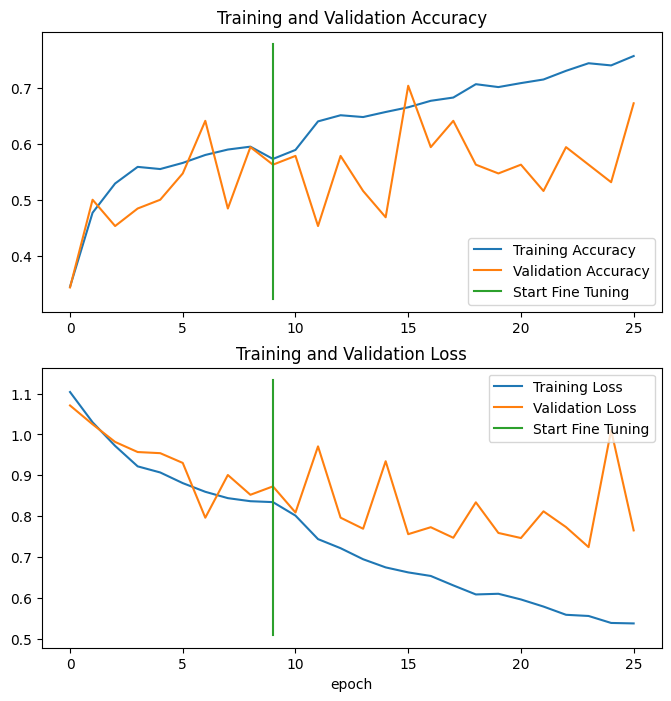

In [26]:
# Compare model_0 to model_0 fine tuned
compare_historys(original_history=history_0,
                 new_history=history_finetune_0,
                 initial_epochs=10)

10
26
[0.34491634368896484, 0.4768339693546295, 0.5289575457572937, 0.5585585832595825, 0.554697573184967, 0.5656370520591736, 0.5797941088676453, 0.5894466042518616, 0.5945945978164673, 0.5727155804634094, 0.5842986106872559, 0.6415701508522034, 0.662162184715271, 0.6833977103233337, 0.7329472303390503, 0.7400257587432861, 0.7509652376174927, 0.7754182815551758, 0.7921493053436279, 0.8037322759628296, 0.8146718144416809, 0.8552123308181763, 0.8462033271789551, 0.876447856426239, 0.8893178701400757, 0.8828828930854797]


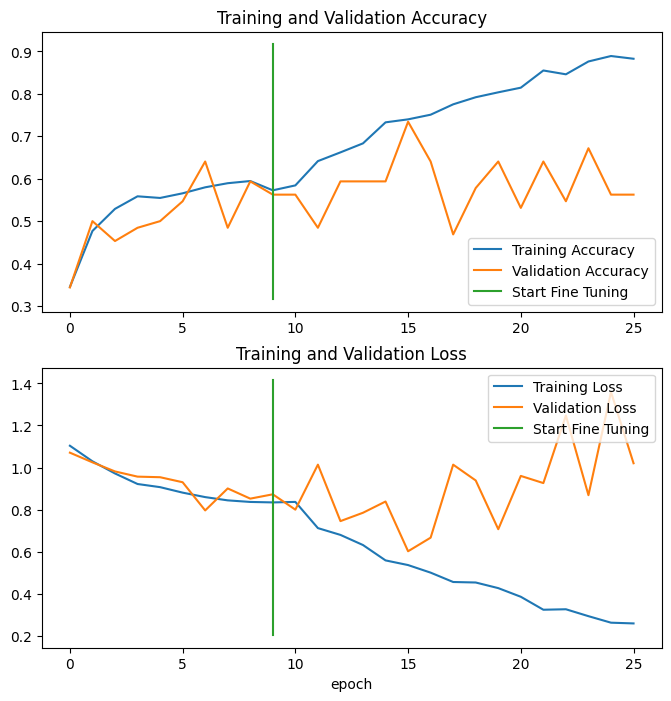

In [27]:
# Compare model_0 to model_1 fine tuned
compare_historys(original_history=history_0,
                 new_history=history_finetune_1,
                 initial_epochs=10)

In [ ]:
# Data preprocessing

IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("Training images: ")
train_generator = datagen.flow_from_directory(
    training_set_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

print("Validation images: ")
validation_generator = datagen.flow_from_directory(
    training_set_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed = 42
)

print("Testing images: ")
test_generator = datagen.flow_from_directory(
    test_set_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed = 42
)

Training images: 
Found 582 images belonging to 3 classes.
Validation images: 
Found 144 images belonging to 3 classes.
Testing images: 
Found 271 images belonging to 3 classes.


In [ ]:
# Create TensorBoard callback (to track experiments)
import datetime
def create_tensorboard_callback(dir_name, exp_name):
    log_dir = dir_name + "/" + exp_name +"/" + datetime.datetime.now().strftime("%Y%M%D-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f"Saving TensorBoard log files to : {log_dir}")
    return tensorboard_callback

In [ ]:
# install the EfficientNet package
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
# import efficientnet.tfkeras as efn
# from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Define a model from the model url
def create_model(model_url, num_classes, set_trainable):
    ftr_extr_layer = hub.KerasLayer(model_url,
                                    trainable = set_trainable, #True, #False,
                                    name = "ftr_extr_layer",
                                    input_shape = (IMG_SIZE,IMG_SIZE,3))
    model = Sequential([
        ftr_extr_layer,
        # GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax')  # 3 classes: BENIGN, MALIGNANT, BENIGN_NO_CALL
    ])
    return model

# base_model = efn.EfficientNetB7(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
# base_model = Xception(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
# base_model.trainable = False  # Freeze layers

# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(3, activation='softmax')  # 3 classes: BENIGN, MALIGNANT, BENIGN_NO_CALL
# ])

model = create_model(res_net_url, num_classes = 3, set_trainable = True) # efn_net_url
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ftr_extr_layer (KerasLayer  (None, 2048)              23561152  
 )                                                               
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23567299 (89.90 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 23561152 (89.88 MB)
_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator), #.samples // BATCH_SIZE,
    # steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = len(validation_generator), #.samples // BATCH_SIZE,
    # validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                             exp_name="resnet50")],
    epochs=20
)

# Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Saving TensorBoard log files to : tensorflow_hub/resnet50/20233610/10/23-193608
Epoch 1/20
19/19 [==============================] - 74s 4s/step - loss: 0.9629 - accuracy: 0.5309 - val_loss: 0.9672 - val_accuracy: 0.4792
Epoch 2/20
19/19 [==============================] - 75s 4s/step - loss: 0.9594 - accuracy: 0.5275 - val_loss: 0.9677 - val_accuracy: 0.5139
Epoch 3/20
19/19 [==============================] - 76s 4s/step - loss: 0.8952 - accuracy: 0.5344 - val_loss: 0.9714 - val_accuracy: 0.4931
Epoch 4/20
19/19 [==============================] - 81s 4s/step - loss: 0.8770 - accuracy: 0.5378 - val_loss: 0.9641 - val_accuracy: 0.4306
Epoch 5/20
19/19 [==============================] - 74s 4s/step - loss: 0.8329 - accuracy: 0.5722 - val_loss: 0.8455 - val_accuracy: 0.5139
Epoch 6/20
19/19 [==============================] - 87s 5s/step - loss: 0.8287 - accuracy: 0.5773 - val_loss: 1.0386 - val_accuracy: 0.4792
Epoch 7/20
19/19 [==============================] - 86s 5s/step - loss: 0.8309 -

KeyboardInterrupt: ignored

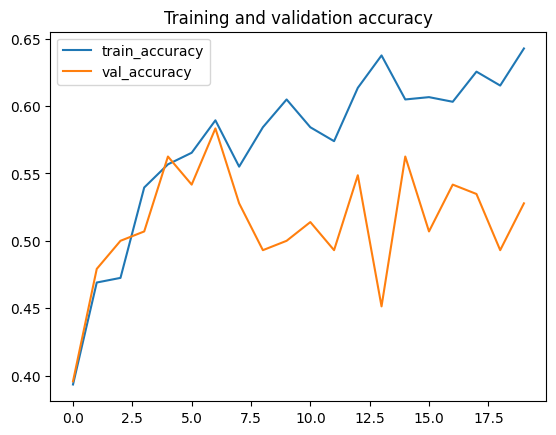

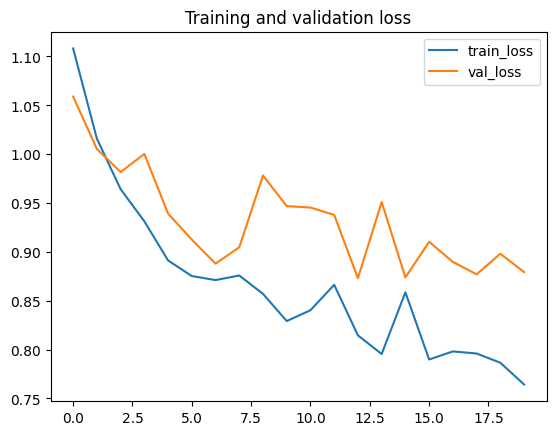